**Saida Huseyn**                                                                                              
**July, 2022**

**Capstone Project** Short term rental analysis: **What makes a super host?** Example of New York City Airbnb rentals.

- **Current Notebook**: Part 3 of 6 "Capstone_Supervised_Classification"
- **Next Notebook**: Part 4 of 6 "Capstone_Random_Forest"

The purpose of this notebook is to try to predict super hosts and interpret the features that contribute to becoming a super host.
The steps to take are: 
- Run basic logistic regression, optimize regularization by choosing best C
- Run basic KNN, optimize neighbours
- Run basic Decision Tree, optimize depth

- Create pipeline for Logistic regression and decision tree

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy import stats
import statsmodels.api as sm
from scipy.stats import norm

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline

np.random.seed(12345)

In [2]:
from sklearn.model_selection import cross_val_score

In [3]:
from tempfile import mkdtemp
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [4]:
%store -r data

In [5]:
data.shape

(37460, 50)

In [6]:
pd.set_option('display.max_columns', None)

In [7]:
data.head(1)

,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,host_months,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Hotel room,Private room,Shared room,amenities_number,wifi,tv,hot water,air conditioning,bathtub,dedicated workspace,board games,sound system,bbq grill,refrigerator
0,0,1,1,40.75356,-73.98559,1,1.0,1.0,1.0,150.0,30,1125,1,30,60,77,334,48,0,0,4.7,4.72,4.62,4.76,4.79,4.86,4.41,0,3,166.0,0,0,1,0,0,1,0,0,0,31,1,1,1,1,1,1,0,0,0,1


In [8]:
data.isna().sum()

host_is_superhost                    0
host_has_profile_pic                 0
host_identity_verified               0
latitude                             0
longitude                            0
accommodates                         0
bathrooms_text                       0
bedrooms                             0
beds                                 0
price                                0
minimum_nights                       0
maximum_nights                       0
has_availability                     0
availability_30                      0
availability_60                      0
availability_90                      0
availability_365                     0
number_of_reviews                    0
number_of_reviews_ltm                0
number_of_reviews_l30d               0
review_scores_rating              8880
review_scores_accuracy            9389
review_scores_cleanliness         9379
review_scores_checkin             9394
review_scores_communication       9385
review_scores_location   

We have missing valued for review columns. Several options to deal with it:
- fill missing values for the training set using KNN Imputer and transform validation and test sets.
- remove rows with missing values for those columns
- remove columns

Every model below will mention which way was used. For the basic X_train set, we will use removed rows dataset, and later we will use KNN imputed values to see if it changes the basic model.

## Train, Validation, Test Split

Before using KNN Imputer for the missing values, we need to split our data into three parts; train, validation and test. We need to keep test set totally away from our data manipulation and model fitting and preserve it for the final model fit to see the close to "real life" performance of our final models.

In [9]:
# check data shape again
data.shape

(37460, 50)

In [10]:
# define the features and the target 

In [11]:
X=data.drop(columns='host_is_superhost')
y=data['host_is_superhost']

In [12]:
# check shapes for X and y
X.shape, y.shape

((37460, 49), (37460,))

First split: split the data into the test and remainder chunks:

In [13]:
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

In [14]:
X_test.shape, y_test.shape

((7492, 49), (7492,))

In [15]:
X_remainder.shape, y_remainder.shape

((29968, 49), (29968,))

Second split: split the remainder into the train and validation sets

In [16]:
# split the remainder into the train and validation sets. 

In [17]:
X_train, X_validation, y_train, y_validation = train_test_split(X_remainder, y_remainder, test_size=0.25, random_state=1, stratify=y_remainder) 

In [18]:
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape

((22476, 49), (22476,), (7492, 49), (7492,))

Train-test split complete.

---

## KNN Imputer

Justification:
Columns related to the review scores are important to identify superhost performance; however, there are more than 8000k misisng values. Thus, we tried to use KNN to generate values for the missing ones. A simpler way of review imputing could be even more biased.


- for reviews; filling in missing values
- create a copy of training, validation and test sets, impute and use the initial index and feature names to make sets comparable to y_sets (target columns)

In [19]:
# copy training set

In [21]:
x_copy=X_train

In [22]:
x_copy.head(1)

,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,host_months,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Hotel room,Private room,Shared room,amenities_number,wifi,tv,hot water,air conditioning,bathtub,dedicated workspace,board games,sound system,bbq grill,refrigerator
24872,1,1,40.74293,-73.97318,4,1.0,1.0,1.0,196.0,30,1125,1,0,0,0,248,2,2,0,4.5,4.0,4.5,5.0,5.0,5.0,4.5,0,63,120.0,0,0,1,0,0,1,0,0,0,26,1,0,1,1,0,0,0,0,0,1


In [23]:
x_copy.shape

(22476, 49)

Normalise before KNN imputing:
- to avoid NAN values use StandardScaler, that will normalize the data keeping the NAN values as is.

In [24]:
#define scaler
scaler = StandardScaler()

In [25]:
#fit the train data
scaler.fit(x_copy)

StandardScaler()

In [26]:
x_copy_s=scaler.transform(x_copy)

Also, transform validation and test sets:

In [27]:
x_val_copy = X_validation
x_test_copy = X_test

In [28]:
x_val_copy_s=scaler.transform(x_val_copy)
x_test_copy_s=scaler.transform(x_test_copy)

Import KNN imputer, fit x_copy and transform validation and test

In [29]:
from sklearn.impute import KNNImputer

In [30]:
# define imputer
knn = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')


In [31]:
# fit on the training copy set
knn.fit(x_copy_s)

KNNImputer()

In [33]:
# transform and convert transformed data into dataframe
x_copy_s = pd.DataFrame(knn.transform(x_copy_s))

In [34]:
x_copy_s.head().isna().sum().sum()

0

In [35]:
x_copy_s.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
0,0.098966,0.443555,0.252809,-0.496903,0.61666,-0.337796,-0.428536,-0.529833,0.261656,0.32144,0.946017,0.475872,-0.721066,-0.808918,-0.867613,0.849126,-0.4251,-0.233962,-0.245113,-0.124773,-1.517476,-0.208461,0.428694,0.417262,0.611996,-0.289905,-0.57002,1.039879,1.278465,-0.179951,-0.783852,1.159493,-0.423786,-0.096648,0.923623,-0.063052,-0.889575,-0.121882,0.239652,0.195694,-0.991141,0.796779,0.480227,-0.506998,-1.246748,-0.170234,-0.121317,-0.252789,1.040599


Training set is fitted and transformed.

No missing values in our training set.

Use KNN Imputer results to transform validation set: in this case, the neighbors analyzed are the neighbors from the train set, and validation set is transfromed accordingly. We also transform test set. 

In [36]:
x_val_copy_s = pd.DataFrame(knn.transform(x_val_copy_s))

In [37]:
x_test_copy_s = pd.DataFrame(knn.transform(x_test_copy_s))

Get feature names back:

In [38]:
x_copy_imputed = pd.DataFrame(knn.transform(x_copy_s), columns = x_copy.columns)

In [39]:
x_copy_imputed.head(2)

,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,host_months,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Hotel room,Private room,Shared room,amenities_number,wifi,tv,hot water,air conditioning,bathtub,dedicated workspace,board games,sound system,bbq grill,refrigerator
0,0.098966,0.443555,0.252809,-0.496903,0.616660,-0.337796,-0.428536,-0.529833,0.261656,0.321440,0.946017,0.475872,-0.721066,-0.808918,-0.867613,0.849126,-0.4251,-0.233962,-0.245113,-0.124773,-1.517476,-0.208461,0.428694,0.417262,0.611996,-0.289905,-0.57002,1.039879,1.278465,-0.179951,-0.783852,1.159493,-0.423786,-0.096648,0.923623,-0.063052,-0.889575,-0.121882,0.239652,0.195694,-0.991141,0.796779,0.480227,-0.506998,-1.246748,-0.170234,-0.121317,-0.252789,1.040599
1,0.098966,-2.254510,0.661555,-0.635352,-0.962293,-0.337796,-0.428536,-0.529833,-0.627336,-0.221175,0.946017,-2.101405,-0.721066,-0.808918,-0.867613,-0.918153,-0.4621,-0.349579,-0.245113,-0.207139,-0.010504,-0.594296,-0.030567,0.201651,0.120232,0.060336,-0.57002,-0.286760,1.053988,-0.179951,-0.783852,1.159493,-0.423786,-0.096648,-1.082693,-0.063052,1.124132,-0.121882,-1.000470,0.195694,-0.991141,-1.255054,0.480227,-0.506998,-1.246748,-0.170234,-0.121317,-0.252789,-0.960985


In [40]:
x_copy_imputed['review_scores_rating'].describe()

count    22476.000000
mean        -0.072109
std          0.956063
min         -5.740641
25%         -0.124773
50%          0.212179
75%          0.449293
max          0.499212
Name: review_scores_rating, dtype: float64

In [41]:
X_train.shape, x_copy_imputed.shape

((22476, 49), (22476, 49))

In [42]:
x_copy_imputed.isna().sum().sum()

0

In [43]:
# X_train=x_copy

In [44]:
x_val_copy_imputed=pd.DataFrame(knn.transform(x_val_copy_s), columns=x_val_copy.columns)

In [45]:
x_val_copy_imputed.head(1)

,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,host_months,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Hotel room,Private room,Shared room,amenities_number,wifi,tv,hot water,air conditioning,bathtub,dedicated workspace,board games,sound system,bbq grill,refrigerator
0,0.098966,0.443555,0.560166,-0.968571,0.090342,-0.337796,-0.428536,-0.529833,0.469718,0.32144,0.946017,0.475872,0.520173,1.112425,1.248262,1.568865,-0.4621,-0.349579,-0.245113,0.436814,0.282744,0.580748,0.199064,-0.264069,0.611996,0.324963,-0.57002,0.691908,0.85757,-0.179951,-0.783852,1.159493,-0.423786,-0.096648,0.923623,-0.063052,-0.889575,-0.121882,0.322327,0.195694,-0.991141,-1.255054,0.480227,-0.506998,0.802087,-0.170234,-0.121317,-0.252789,1.040599


In [46]:
x_test_copy_imputed = pd.DataFrame(knn.transform(x_test_copy_s), columns=x_test_copy.columns)

In [47]:
x_test_copy_imputed.head(1)

,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,host_months,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Hotel room,Private room,Shared room,amenities_number,wifi,tv,hot water,air conditioning,bathtub,dedicated workspace,board games,sound system,bbq grill,refrigerator
0,0.098966,0.443555,-0.7469,0.041634,-0.435975,-0.337796,-0.428536,0.089275,-0.658861,0.32144,0.946017,0.475872,-0.721066,-0.808918,-0.781835,0.385928,-0.4251,-0.291771,-0.245113,0.499212,0.518972,0.668438,0.428694,0.417262,0.611996,0.682987,-0.57002,-0.134523,0.268318,-0.179951,1.275752,-0.862446,-0.423786,-0.096648,-1.082693,-0.063052,1.124132,-0.121882,-0.66977,0.195694,-0.991141,-1.255054,-2.08235,-0.506998,0.802087,-0.170234,-0.121317,-0.252789,-0.960985


In [48]:
X_validation.shape, x_val_copy_imputed.shape

((7492, 49), (7492, 49))

In [49]:
X_test.shape, x_test_copy_imputed.shape

((7492, 49), (7492, 49))

Get indexes back:
- as during scaling and the KNN imputing indexes were set to the default, we lost row names corresponding to the target column indexes. That will create a problem during modelling. We need to restore indexes first.

In [50]:
x_copy_imputed.index = X_train.index

In [51]:
x_copy_imputed.head(1)

,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,host_months,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Hotel room,Private room,Shared room,amenities_number,wifi,tv,hot water,air conditioning,bathtub,dedicated workspace,board games,sound system,bbq grill,refrigerator
24872,0.098966,0.443555,0.252809,-0.496903,0.61666,-0.337796,-0.428536,-0.529833,0.261656,0.32144,0.946017,0.475872,-0.721066,-0.808918,-0.867613,0.849126,-0.4251,-0.233962,-0.245113,-0.124773,-1.517476,-0.208461,0.428694,0.417262,0.611996,-0.289905,-0.57002,1.039879,1.278465,-0.179951,-0.783852,1.159493,-0.423786,-0.096648,0.923623,-0.063052,-0.889575,-0.121882,0.239652,0.195694,-0.991141,0.796779,0.480227,-0.506998,-1.246748,-0.170234,-0.121317,-0.252789,1.040599


In [52]:
x_val_copy_imputed.index = X_validation.index

In [53]:
x_test_copy_imputed.index = X_test.index

In [54]:
x_val_copy_imputed.head(1)

,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,host_months,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Hotel room,Private room,Shared room,amenities_number,wifi,tv,hot water,air conditioning,bathtub,dedicated workspace,board games,sound system,bbq grill,refrigerator
24141,0.098966,0.443555,0.560166,-0.968571,0.090342,-0.337796,-0.428536,-0.529833,0.469718,0.32144,0.946017,0.475872,0.520173,1.112425,1.248262,1.568865,-0.4621,-0.349579,-0.245113,0.436814,0.282744,0.580748,0.199064,-0.264069,0.611996,0.324963,-0.57002,0.691908,0.85757,-0.179951,-0.783852,1.159493,-0.423786,-0.096648,0.923623,-0.063052,-0.889575,-0.121882,0.322327,0.195694,-0.991141,-1.255054,0.480227,-0.506998,0.802087,-0.170234,-0.121317,-0.252789,1.040599


In [55]:
x_test_copy_imputed.head(1)

,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,host_months,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Hotel room,Private room,Shared room,amenities_number,wifi,tv,hot water,air conditioning,bathtub,dedicated workspace,board games,sound system,bbq grill,refrigerator
25792,0.098966,0.443555,-0.7469,0.041634,-0.435975,-0.337796,-0.428536,0.089275,-0.658861,0.32144,0.946017,0.475872,-0.721066,-0.808918,-0.781835,0.385928,-0.4251,-0.291771,-0.245113,0.499212,0.518972,0.668438,0.428694,0.417262,0.611996,0.682987,-0.57002,-0.134523,0.268318,-0.179951,1.275752,-0.862446,-0.423786,-0.096648,-1.082693,-0.063052,1.124132,-0.121882,-0.66977,0.195694,-0.991141,-1.255054,-2.08235,-0.506998,0.802087,-0.170234,-0.121317,-0.252789,-0.960985


Column names and indexes are restored

Values imputed, no missing values, we can model the data

In [56]:
%store x_copy_imputed

Stored 'x_copy_imputed' (DataFrame)


In [57]:
%store x_val_copy_imputed

Stored 'x_val_copy_imputed' (DataFrame)


In [58]:
%store x_test_copy_imputed

Stored 'x_test_copy_imputed' (DataFrame)


Stored variables

Rename and use as X_train, X_val, and X_test

In [59]:
X_train= x_copy_imputed

In [60]:
X_val = x_val_copy_imputed

In [61]:
X_test = x_test_copy_imputed

In [62]:
%store X_train

Stored 'X_train' (DataFrame)


In [63]:
%store X_val

Stored 'X_val' (DataFrame)


In [64]:
%store X_test

Stored 'X_test' (DataFrame)


---

## Scale the data using Standard Scaler

As our data is already scaled for the purposes of KNN imputer, no need to scale it again. We will use this data for Logistic regression, KNN and Decision trees. Although Decision trees don't require a scaled data as it is not a distance-based model.

## Basic Logistic Regression

Run basic model:

In [73]:
clf = LogisticRegression(random_state=0, solver='lbfgs', max_iter=10000).fit(X_train, y_train)
# running basic Logistic regression model
# solver set to lbfgs
# number of max iterations set to 10000 as the model cannot converge at lower iterations
# random_state ensures the same results when the model is runned
# using scaled data

In [75]:
# extract train score
clf.score(X_train, y_train)

0.8327549386011746

In [76]:
coef = clf.coef_
coef

array([[ 0.04492976,  0.010942  , -0.12499021,  0.13211015, -0.07641917,
        -0.04741668,  0.04883547,  0.05640624, -0.03796839, -0.02626062,
        -0.07824166,  1.50043322,  0.03254618, -0.12354929, -0.0129412 ,
         0.02751722,  0.28409985,  0.44970139, -0.13997061,  1.57505793,
         0.03396083,  0.41395405,  0.07841359,  0.55776644, -0.14656875,
        -0.05873308, -0.07317348,  0.24613771,  0.07703017,  0.05884664,
        -0.00437716, -0.00471058, -0.02784586,  0.04387972, -0.03380004,
        -0.32601892,  0.07447888,  0.00279377,  0.5214531 , -0.10573571,
         0.08686423,  0.08039264,  0.00486832, -0.15782618,  0.04891729,
        -0.04746786,  0.02114828, -0.07965686,  0.05599833]])

In [86]:
# extract names of all features (columns) in the dataset, name the list
feature_list=list(X_train.columns)


In [78]:
#convert array of coefficients into the dataframe
coef_df= pd.DataFrame(coef, columns=feature_list)
coef_df

,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,host_months,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Hotel room,Private room,Shared room,amenities_number,wifi,tv,hot water,air conditioning,bathtub,dedicated workspace,board games,sound system,bbq grill,refrigerator
0,0.04493,0.010942,-0.12499,0.13211,-0.076419,-0.047417,0.048835,0.056406,-0.037968,-0.026261,-0.078242,1.500433,0.032546,-0.123549,-0.012941,0.027517,0.2841,0.449701,-0.139971,1.575058,0.033961,0.413954,0.078414,0.557766,-0.146569,-0.058733,-0.073173,0.246138,0.07703,0.058847,-0.004377,-0.004711,-0.027846,0.04388,-0.0338,-0.326019,0.074479,0.002794,0.521453,-0.105736,0.086864,0.080393,0.004868,-0.157826,0.048917,-0.047468,0.021148,-0.079657,0.055998


In [79]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

#fit the model
Logis_model = LogisticRegression(random_state=0, solver='lbfgs', max_iter=10000)
Logis_model.fit(X_train, y_train)

# Get class predictions
y_pred = Logis_model.predict(X_val)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_validation, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
        cf_matrix, 
        columns=["Predicted Negative Rating", "Predicted Positive Rating"],
        index=["True Negative Rating", "True Positive Rating"]
 )

display(cf_df)

,Predicted Negative Rating,Predicted Positive Rating
True Negative Rating,5667,267
True Positive Rating,995,563


Let's plot the confusion matrix for the better visuality

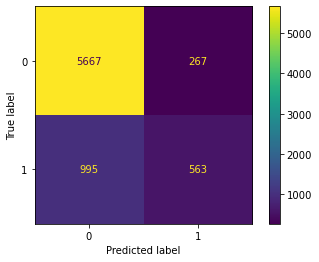

In [80]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [82]:
# Precision 
from sklearn.metrics import precision_score

# precision_score(true labels, predicted labels)
precision_score(y_validation, y_pred)

0.6783132530120481

In [83]:
# Recall
from sklearn.metrics import recall_score

#recall_score(true labels, predicted labels)
recall_score(y_validation, y_pred)

0.3613607188703466

In [84]:
from sklearn.metrics import f1_score

f1_score(y_validation, y_pred)

0.4715242881072027

In [85]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_validation, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      5934
           1       0.68      0.36      0.47      1558

    accuracy                           0.83      7492
   macro avg       0.76      0.66      0.69      7492
weighted avg       0.81      0.83      0.81      7492



As we see, even if the score is 83%, slightly higher than the underlying class distribution, confusion matrix shows high degree of FP and FN errors: precision is 68% and recall is 36% which is very low. 

- the basic model predicts others better than the superhosts. I might be related to class imbalance. 
- for now, let's try to optimize C values.

---

### Basic C optimization

In [87]:
# We will try to optimize C values by using the following range and using power of 10 as regularization measure
C_range = 10.**np.arange(-3, 3)

train_acc = []
validation_acc = []

for C in C_range: 
    print(f"Working on my model with C={C}...", end="\r")
    
    #Instantiate the model & fit it to our data
    LR_model = LogisticRegression(C=C, max_iter=10000)
    LR_model.fit(X_train, y_train)
    
    #Score the model on the test set
    train_accuracy = LR_model.score(X_train, y_train)
    validation_accuracy = LR_model.score(X_val, y_validation)
    
    train_acc.append(train_accuracy)
    validation_acc.append(validation_accuracy)
    precision_score(y_validation, y_validation)
    recall_score(y_validation, y_validation)

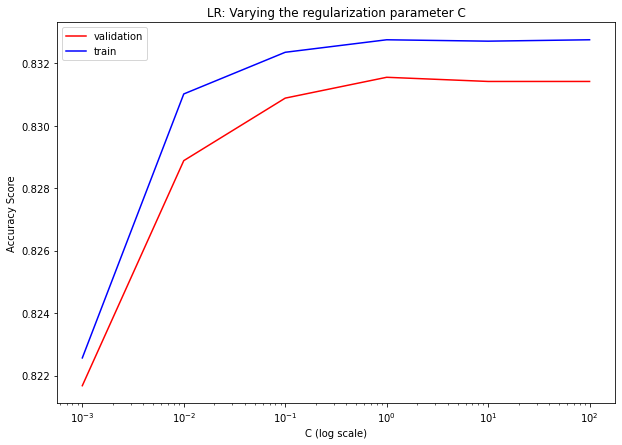

In [88]:
plt.figure(figsize=(10, 7))
plt.plot(C_range, validation_acc, color="red", label="validation")
plt.plot(C_range, train_acc, color="blue", label="train")
plt.ylabel("Accuracy Score")
plt.xlabel("C (log scale)")
plt.xscale("log")
plt.title('LR: Varying the regularization parameter C')
plt.legend()
plt.show()

Regularization does not help to improve the model performance

---

## Basic KNN
- use scaled data

In [92]:
#from sklearn.neighbors import KNeighborsClassifier

# Split our data into train & test sets

# Instantiate the model & fit it to our data using 3 neighbours
KNN_model = KNeighborsClassifier(n_neighbors=3)
KNN_model.fit(X_train, y_train)

# Score the model on the test set
validation_predictions = KNN_model.predict(X_val)
validation_accuracy = accuracy_score(validation_predictions, y_validation)
print(f"Validation set accuracy: {validation_accuracy}")



Validation set accuracy: 0.8231446876668447


In [91]:
Default KNN model using

KNN_model = KNeighborsClassifier()
KNN_model.fit(X_train, y_train)

print("Number of neighbors:", KNN_model.n_neighbors)
print("Train accuracy:", KNN_model.score(X_train, y_train))
print("Validation accuracy:", KNN_model.score(X_val, y_validation))

Number of neighbors: 5
Train accuracy: 0.8811621284926143
Validation accuracy: 0.8282167645488521


With increased number of neighbors, training set performance increase, validation set accuracy dropped. let's optimize k-neighnours values further.

In [94]:
# define the range for k-values from 1 to 19

neighbors = range(1, 20)  # step by 2 so only odd numbers show up

train_acc = []
validation_acc = []

for n in neighbors: 
    print(f"Working on my model with {n} neighbors...", end="\r")
    
    #Instantiate the model & fit it to our data
    KNN_model = KNeighborsClassifier(n_neighbors=n)
    KNN_model.fit(X_train, y_train)
    
    #Score the model on the test set
    train_accuracy = KNN_model.score(X_train, y_train)
    validation_accuracy = KNN_model.score(X_val, y_validation)
    
    train_acc.append(train_accuracy)
    validation_acc.append(validation_accuracy)

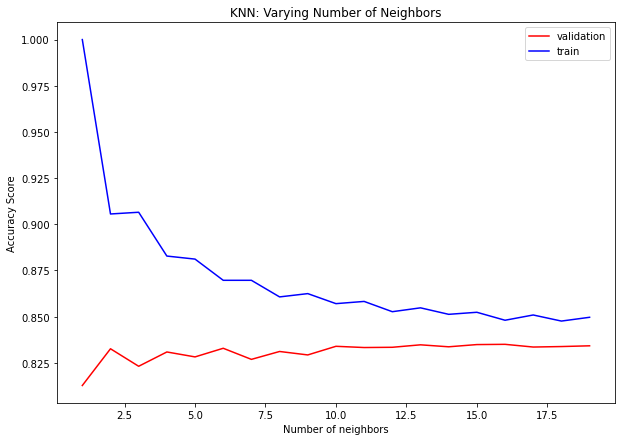

In [95]:
plt.figure(figsize=(10, 7))
plt.plot(neighbors, validation_acc, color="red", label="validation")
plt.plot(neighbors, train_acc, color="blue", label="train")
plt.ylabel("Accuracy Score")
plt.xlabel("Number of neighbors")
plt.title('KNN: Varying Number of Neighbors')
plt.legend()
plt.show()
# over, underfitting analysis

In [96]:
#Calculate the ideal k value: 

# index the value that is largest in the test accuracy
index_of_max = np.argmax(validation_acc)

# the corresponding best k value
best_k = neighbors[index_of_max]

best_k

16

In [98]:
# Best-k KNN model

KNN_model = KNeighborsClassifier(n_neighbors=16)
KNN_model.fit(X_train, y_train)

print("Number of neighbors:", KNN_model.n_neighbors)
print("Train accuracy:", KNN_model.score(X_train, y_train))
print("Validation accuracy:", KNN_model.score(X_val, y_validation))

Number of neighbors: 16
Train accuracy: 0.8480601530521445
Validation accuracy: 0.8350240256273358


Accuracy for Validation increased by 1% only. Let's see how the confusion matrix looks.

Build a confusion matrix for KNN (neigh=16)

In [99]:
#fit the model
KNN_model = KNeighborsClassifier(n_neighbors=16)
KNN_model.fit(X_train, y_train)

# Get class predictions
y_pred = KNN_model.predict(X_val)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_validation, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
        cf_matrix, 
        columns=["Predicted Negative Rating", "Predicted Positive Rating"],
        index=["True Negative Rating", "True Positive Rating"]
 )

display(cf_df)

,Predicted Negative Rating,Predicted Positive Rating
True Negative Rating,5676,258
True Positive Rating,978,580


In [100]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_validation, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      5934
           1       0.69      0.37      0.48      1558

    accuracy                           0.84      7492
   macro avg       0.77      0.66      0.69      7492
weighted avg       0.82      0.84      0.81      7492



Accuracy increased to 84%.
Compared to Logistic Regression, KNN basic performs slightly better with f-score 0.48 compared to 0.47, and precision and recall also increased by 0.01. This is a negligible improvement. results are almost identical. The models fail to predict super hosts. Possible reason:
- Airbnb labelling of the superhosts is managed by other factors not presented in our dataset and features in ou dataset are not powerful enough to show the difference in two classes. 
- Sample size is small for the superhost samples and combined with the previous reason, it makes impossible for the model to predict superhosts. It just predicts everybody ans not-superhost (as the most representative group in the model)

---

## Decision Trees

Create a basic model, to avoid overfitting use depth from 1 to 9 and see if the model reaches its optimum; less overfitting in trainign set, and maximized accuracy in validation set.

In [101]:
# list for storing accuracy for train and validation
train_acc = []
validation_acc = []

# loop over max_depth values
for depth in range(1, 10):
    print(f"Fitting with max depth = {depth}")
    # fit the tree
    my_tree = DecisionTreeClassifier(max_depth=depth)
    my_tree.fit(X_train, y_train)
    
    # score on train and append accuracy to list
    train_acc.append(my_tree.score(X_train, y_train))
    
    # score on validation and append to list
    validation_acc.append(my_tree.score(X_val, y_validation))

Fitting with max depth = 1
Fitting with max depth = 2
Fitting with max depth = 3
Fitting with max depth = 4
Fitting with max depth = 5
Fitting with max depth = 6
Fitting with max depth = 7
Fitting with max depth = 8
Fitting with max depth = 9


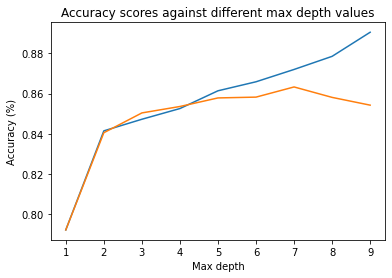

In [102]:
# plot the accuracy scores
plt.figure()
plt.plot(range(1, 10), train_acc, label="train")
plt.plot(range(1, 10), validation_acc, label="valdiation")
plt.title("Accuracy scores against different max depth values")
plt.xlabel("Max depth")
plt.ylabel("Accuracy (%)")
plt.show()

Depth=7 looks like the optimum depth. Let's build a model based on that hyperparameter

In [104]:
    # fit the tree
    my_tree_7 = DecisionTreeClassifier(max_depth=7)
    my_tree_7.fit(X_train, y_train)
    
    # score on train and append accuracy to list
    train_acc=my_tree_7.score(X_train, y_train)
    
    # score on validation and append to list
    validation_acc = my_tree_7.score(X_val, y_validation)
    
    print(f'train score {train_acc}, validation score {validation_acc}')

train score 0.8720412884854957, validation score 0.8634543513080619


In [106]:
# Get class predictions
y_pred_dt = my_tree_7.predict(X_val)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_validation, y_pred_dt)

# label rows and columns
cf_df = pd.DataFrame(
        cf_matrix, 
        columns=["Predicted Negative Rating", "Predicted Positive Rating"],
        index=["True Negative Rating", "True Positive Rating"]
 )

display(cf_df)

,Predicted Negative Rating,Predicted Positive Rating
True Negative Rating,5570,364
True Positive Rating,659,899


In [107]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_validation, y_pred_dt)
print(report_initial)

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      5934
           1       0.71      0.58      0.64      1558

    accuracy                           0.86      7492
   macro avg       0.80      0.76      0.78      7492
weighted avg       0.86      0.86      0.86      7492



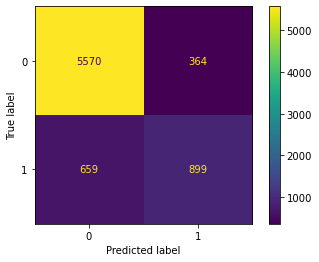

In [108]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

**Model result**:

Basic Decision Tree with optimized depth to 7 performs significantly better than the logistic regression and the KNN model optimized for the basic parameters.
- Recall is 58% and f-score increased to 0.64. Precision is 71%, with accuracy being 86%


**Possible reasons**
- Decision trees are free from distancing bias; they don't use distance for the measure. They employ the most informative node (feature) and try to set thresholds to attach a sample to a target class. As our EDA showed no linear or similar to linear relation among variables, Decision tree is better model for such a dataset.

Let's try to plot our model:

In [110]:
from sklearn.tree import plot_tree

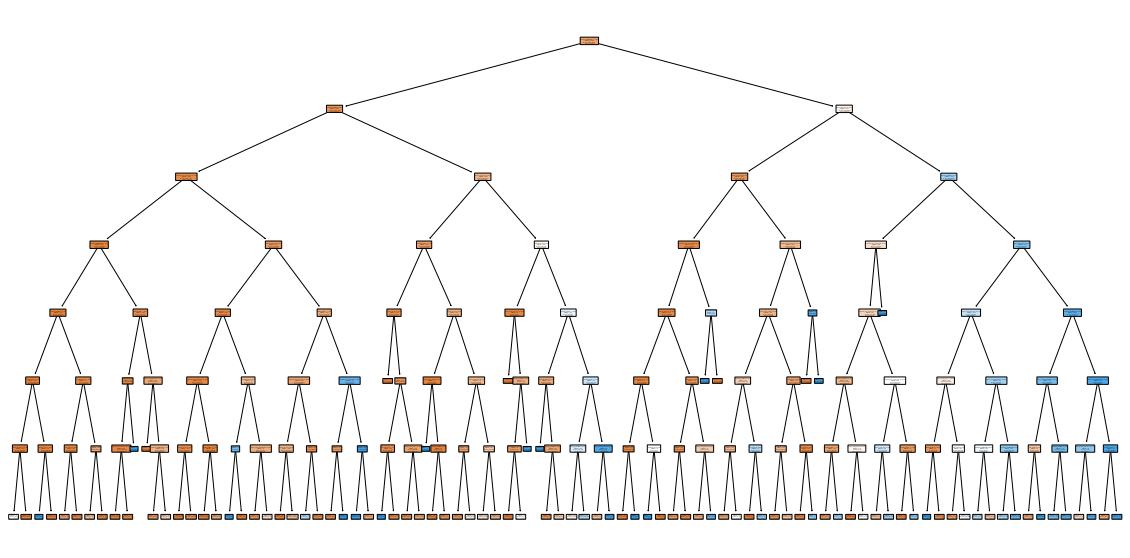

In [129]:
fig = plt.figure(figsize=(20,10))
plot_tree(my_tree_7, 
          feature_names=X.columns, 
          class_names=["Superhost", "Others"],
          rounded=True,
          impurity=False,
          filled=True);

fig.savefig("decistion_tree.png")

---

## Random Forest

As our decision tree performed slighlty better for this dataset, let's boost its performance by using 100 random trees; i.e. a random forest. 

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [66]:
rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [67]:
rf.predict(X_val)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [68]:
# score on train
train_acc=rf.score(X_train, y_train)
    
# score on validation 
validation_acc = rf.score(X_val, y_validation)
    
print(f'train score {train_acc}, validation score {validation_acc}')

train score 1.0, validation score 0.8781366791243994


There is a sign of overfitting, but the accuracy of the validation set also increased.

In [70]:
from sklearn.metrics import classification_report

In [72]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

In [73]:
# Get class predictions
y_pred_dt = rf.predict(X_val)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_validation, y_pred_dt)

# label rows and columns
cf_df = pd.DataFrame(
        cf_matrix, 
        columns=["Predicted Negative Rating", "Predicted Positive Rating"],
        index=["True Negative Rating", "True Positive Rating"]
 )

display(cf_df)

,Predicted Negative Rating,Predicted Positive Rating
True Negative Rating,5706,228
True Positive Rating,685,873


In [74]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_validation, y_pred_dt)
print(report_initial)

              precision    recall  f1-score   support

           0       0.89      0.96      0.93      5934
           1       0.79      0.56      0.66      1558

    accuracy                           0.88      7492
   macro avg       0.84      0.76      0.79      7492
weighted avg       0.87      0.88      0.87      7492



Let's analyze feature importances based on this model:

In [75]:
rf.feature_importances_

array([0.00048093, 0.00398818, 0.03787056, 0.03643227, 0.01426345,
       0.00601824, 0.00628194, 0.01040867, 0.03533041, 0.03115038,
       0.01953732, 0.01286863, 0.01722531, 0.02057092, 0.02485885,
       0.03922818, 0.09691246, 0.08020305, 0.01747336, 0.06809865,
       0.03975553, 0.0452749 , 0.0258002 , 0.03258734, 0.0240097 ,
       0.04099714, 0.00619513, 0.0443129 , 0.0392661 , 0.00174185,
       0.00426473, 0.00429653, 0.00338583, 0.00067033, 0.00422324,
       0.00018426, 0.00412319, 0.00092958, 0.05097811, 0.00157046,
       0.00584815, 0.00848202, 0.00374508, 0.00538006, 0.00508592,
       0.00156863, 0.00156268, 0.00263342, 0.01192523])

In [81]:
fi_df=pd.DataFrame(rf.feature_importances_)

In [1]:
# fi_df.sort_values(ascending=False).head()

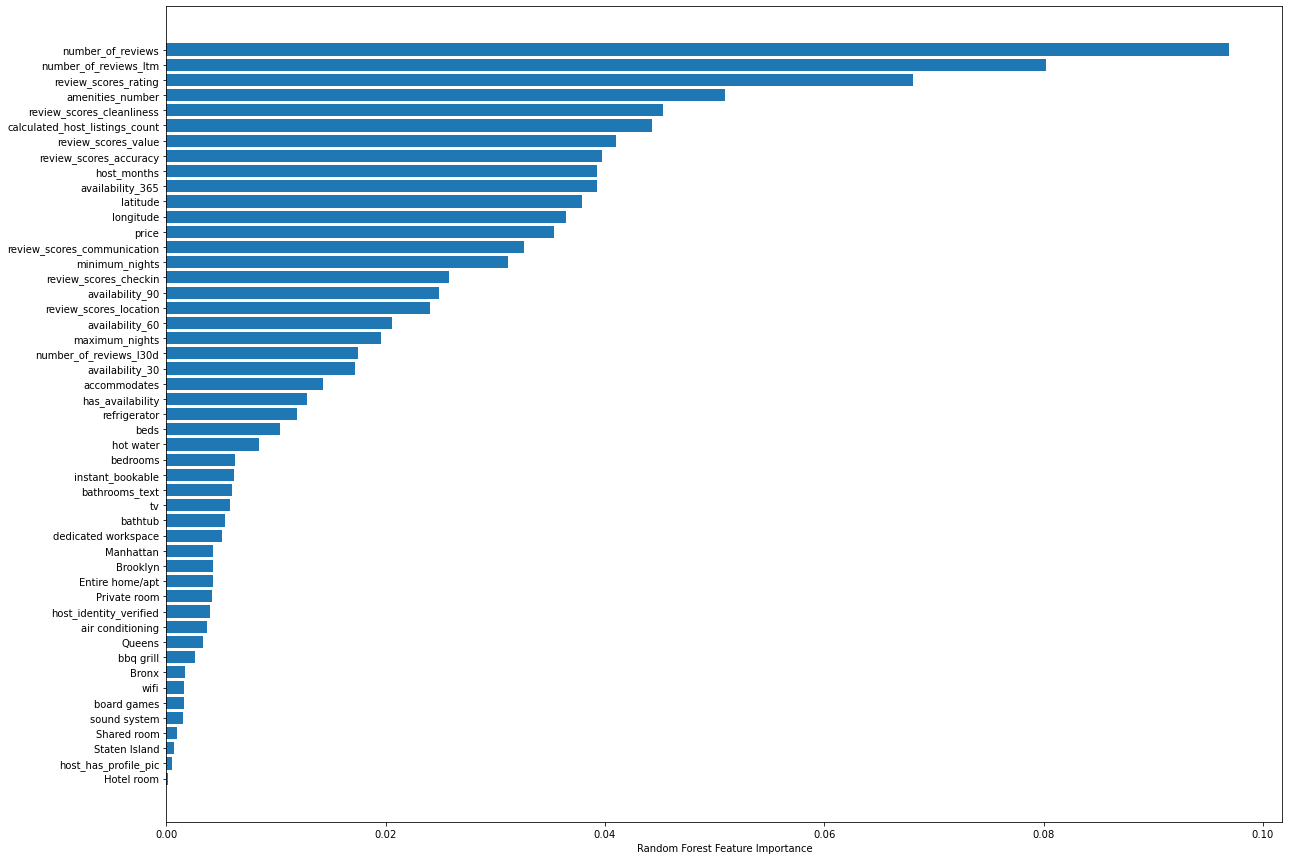

In [85]:
sorted_idx = rf.feature_importances_.argsort()
plt.figure(figsize=(20,15))
plt.barh(X_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance");

### Feature Importances:

Based on our Random Forest model:
- Number of reviews and number of reviews in recent 12 months are the best predictors of a host being a superhost
- Followed by review_scores_rating which is a combined rating based on many qualities of the property, location and host service. Specifically, review_scores_cleaneliness stand out. Initial observation is; people also write the most about cleanliness in their text reviews. Further NLP analysis needed to understand the main topics discussed in reviews and even use only those parameters to predict a super host.
- Number of amenities play main role both in pricing and host being a superhost. This is more significant than a specific type of amenity.
- Hosts being longer in the market and having more available days also inflences performance positively.
- Host listings count seems to be an influencial feature, although this feature is one that customers don't care about. Probably Airbnb weights hosts with more listings positively.

---

## Ensemble learning: Bagging Classifier using DTs

As we know, Random Classifier is an extention of the bagging ensemble with decisin trees. However, it would be interesting how independent decision treen in a bag perform 

In [135]:
from sklearn.ensemble import BaggingClassifier

In [136]:
from sklearn.tree import DecisionTreeClassifier

In [137]:
ensemble_of_DT = BaggingClassifier(DecisionTreeClassifier(),
                                   n_estimators=100,
                                   random_state=1)
ensemble_of_DT.fit(X_train, y_train)

print(f"The classification accuracy of our model on the validation set "
      f"is: {ensemble_of_DT.score(X_val, y_validation)}\n\n")

The classification accuracy of our model on the validation set is: 0.8814735718099306




In [139]:
# Get class predictions
y_pred_ens_dt = ensemble_of_DT.predict(X_val)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_validation, y_pred_ens_dt)

# label rows and columns
cf_df = pd.DataFrame(
        cf_matrix, 
        columns=["Predicted Negative Rating", "Predicted Positive Rating"],
        index=["True Negative Rating", "True Positive Rating"]
 )

display(cf_df)

,Predicted Negative Rating,Predicted Positive Rating
True Negative Rating,5653,281
True Positive Rating,607,951


In [140]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_validation, y_pred_ens_dt)
print(report_initial)

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      5934
           1       0.77      0.61      0.68      1558

    accuracy                           0.88      7492
   macro avg       0.84      0.78      0.80      7492
weighted avg       0.88      0.88      0.88      7492



Ensemble model for Decision Trees performes better than any previous models. However, all those models are not the best for imbalanced data. Further, we will try to solve some imbalanced data problem by using cross-validation and kfold paramenters and also calculate ROC mean for the model. If this does not improve the model, upsampling or downsampling the data could be the next step before trying any model. 

## Predict the test set using ensemble model:

In [148]:
# Get class predictions
y_pred_ens_dt = ensemble_of_DT.predict(X_test)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_ens_dt)

# label rows and columns
cf_df = pd.DataFrame(
        cf_matrix, 
        columns=["Predicted Negative Rating", "Predicted Positive Rating"],
        index=["True Negative Rating", "True Positive Rating"]
 )

display(cf_df)

,Predicted Negative Rating,Predicted Positive Rating
True Negative Rating,5667,267
True Positive Rating,611,947


In [149]:
report_initial = classification_report(y_test, y_pred_ens_dt)
print(report_initial)

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      5934
           1       0.78      0.61      0.68      1558

    accuracy                           0.88      7492
   macro avg       0.84      0.78      0.81      7492
weighted avg       0.88      0.88      0.88      7492



The good news, our best model performed slightly better on test set. Almost the same results, meaning training did not overfit, and there was minimal information leak from model to model. Precision improved by 0.01 the other two values remain the same. Accuracy on the test set is 88%.

This accuracy result was improved from 83% initially (83% on validation set).

### Imbalanced Classification: adjust bagging

In [141]:
# bagged decision trees on an imbalanced classification problem
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier

In [2]:
# # define model
# model = BaggingClassifier(DecisionTreeClassifier(),
#                                    n_estimators=100,
#                                    random_state=1)
# model.fit(X_train, y_train)
# # define evaluation procedure
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# # evaluate model
# scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

# # summarize performance
# print(f"The classification accuracy of our model on the validation set "
#       f"is: {ensemble_of_DT.score(X_val, y_validation)}\n\n")
# print('Mean ROC AUC: %.3f' % mean(scores))


In [3]:
# # Get class predictions
# y_pred_ens_dt = model.predict(X_val)

# # Generate confusion matrix
# cf_matrix = confusion_matrix(y_validation, y_pred_ens_dt)

# # label rows and columns
# cf_df = pd.DataFrame(
#         cf_matrix, 
#         columns=["Predicted Negative Rating", "Predicted Positive Rating"],
#         index=["True Negative Rating", "True Positive Rating"]
#  )

# display(cf_df)

In [4]:
# report_initial = classification_report(y_validation, y_pred_ens_dt)
# print(report_initial)